# 第10回 補足 因果推論


# はじめに

最終課題に取り組むにあたり、企業の課題を発見した後に、その課題を解決するような施策を考案したとしましょう。そこで、実際に「売上が〇〇円が上がります」といったように施策の定量的な効果を伝えて、説得力を持たせたい場面もあると思います。

もしくは、これまで企業が行ってきたマーケティングなどの施策が本当に効果を持っていたのかを検証したり、どういった層に対して最も効果を持っていたのかを調べてみるのも、最終課題の取り組み方の1つとしてあり得ると思います。

そういったときに、ぜひ使うことを考えていただきたいのが**因果推論**です。この教材では、因果関係とは何かから始まり、これまで勉強してきた回帰分析や機械学習を用いて因果効果を推定する方法を一から紹介します。

なお、こちらの教材では最低限説明に必要な統計学を用いますが、慣れていない場合は、因果推論のアイデアを掴むだけでも十分最終課題の参考になると思うので、全て理解しようと気負わずにぜひ勉強してみてください！！

# 目次

1.   因果効果とバイアス
2.   機械学習を用いた因果推論
3.   最終課題に近いケースでの演習



# 1. 因果効果とバイアス

## 因果効果とは?

**そもそもなぜ因果効果を求めたいのでしょうか。因果効果を求めることは単純な比較とはどのように違うのでしょうか。**以下の問題でそれを考えてみましょう。

問題：以下の推論の問題点を指摘してください。

1. 気温とアイスの売上額の相関係数は0.8であったため、東京都内のアイスをすべて買うことによって気温を上昇させることができます。

2. ある会社がマスクを売るために10月にキャンペーン施策を実施したとしましょう。その結果、施策実施前の9月と比べて実施後の11月にはマスクの売上が全国で100万枚増えたとします。これより、施策は100万枚売上枚数を上げる効果がありました。

3. ある会社が売上を伸ばすために、会員登録をしている人に対して、メールでキャンペーン施策を行ったとします。それによって、メールを受け取った人とメールを受け取っていない人で10000円ほど商品の購入金額に違いがあることが分かりました。これによって、メールが売上を1人10000円ほど上げる効果を持っていたと言えます。


最初の例から確認していきましょう。**アイスと気温の例はわかりやすく相関関係と因果関係を混同しています。**気温が高くなったためにアイスを買う人が増えたという関係を逆に捉えてしまったことによる誤謬です。一般化すると、何かしらの数を増やす（減らす）ことによって、他の変数がどのように変化するのかということと、相関があるということは違うということです。

まず次にマスクの例です。一般的に、施策の前後には様々な要因が入り込むため、その施策自体に効果があったのか、正確にはわかりにくくなることがあります。この例だと、10月前後という季節の変わり目なので、気候の変化で自然にマスクの売上が増加することが考えられますね。この例はとても極端なので、その比較はおかしいとすぐ気付くことができますが、**他にも要因がいろいろと考えられるケースでは、何が施策自体の効果がわかりにくくなります。**

もう1つの方も分かりやすい例かもしれません。施策の対象となる人ですが、そもそも会員登録をしていて、メールをきちんとチェックする人は、その会社の商品にもともと興味がある可能性が高いです。一方で、メール配信を受け取る設定に指定ない人は、そもそもその商品にそこまで強い関心がないと考えられます。そういった2つのグループを比べたときに、前者の方が売上が高いのは自然なような気がします。これを施策による効果と言うのは難しいですね。

**これらのうち、特に最後のバイアスは、後に説明するように交絡変数(Confonder)によるバイアスと一般化することができます。**こういったバイアスを取り除くことは単純な比較では難しいので、因果効果をどのような条件のもとで推定できるのかを確認していきましょう。




## RCTとセレクションバイアス

### 用語の整理

| 確率変数 | 名前 | 例 |
|---------|------|-------|
| T | 処置 | マーケティングメール |
| Y | アウトカム | （実際の）購買額 |
| Y(1), Y(0) | ポテンシャルアウトカム | 処置を受けた／受けなかった場合のアウトカム |
| X | 共変量 | 性別、年齢、過去の購買額etc...|

ここで一度、因果推論の文脈で良く使われる用語を整理します。まず、これまで「施策」と書かれきたものは、**処置（トリートメント、Treatment）**と呼ばれています。処置の有無を表す二値の確率変数をここでは$T$で表し、$T=1$のときに処置を受ける、$T=0$のときに処置を受けない、と表すこととします。反対に、処置を受けないことを**制御（コントロール, Control）**と呼びます。



次に、例えば、マーケティングでいうところの売上のように、処置後の変化に関心のある変数は**アウトカム**と呼ばれています。アウトカムを表す確率変数を$Y$と置きます。

そして、ここが因果推論特有であり、少しむずかしいポイントなのですが、**ポテンシャルアウトカム**というものを導入します。確率変数$Y(1)$をある人が処置を受けた場合のアウトカムの値、$Y(0)$をある人が処置を受けなかった場合のアウトカムの値として定義します。

この概念のポイントとしては、実際にある人が処置を受けたかどうかに関わらず、その人に対して$Y(1)$も$Y(0)$のどちらも定義されるということです。つまり、$Y(1)$と$Y(0)$のどちらかは、反事実・反実仮想(Counterfactual)なものになります。これは「因果推論の根本問題」と呼ばれており、ある個人$i$について、$Y_i(1)$と$Y_i(0)$の両方を観測することは不可能であるという問題です。

そして、このポテンシャルアウトカムの記法を用いて、**ある個人iが処置を受けた場合の因果効果**を$Y_i(1) - Y_i(0)$と定義することとします。


最後に、その人の処置を受ける前の状況や属性を表す確率変数を$X$として、**共変量**と呼びます。例えば、性別や年齢などの属性、もしくは、マーケティングの例であれば、いつ会員登録をしたか、これまでどのくらいの商品を購入したかなどの情報を含んでいます。

### セレクションバイアス

さて、では先程の交絡変数の話題に戻りましょう。**先ほどの3つ目のマーケティングにおけるセレクションバイアスの例で考察を進めていきます。**セレクションバイアスを表した図が下のようになります。

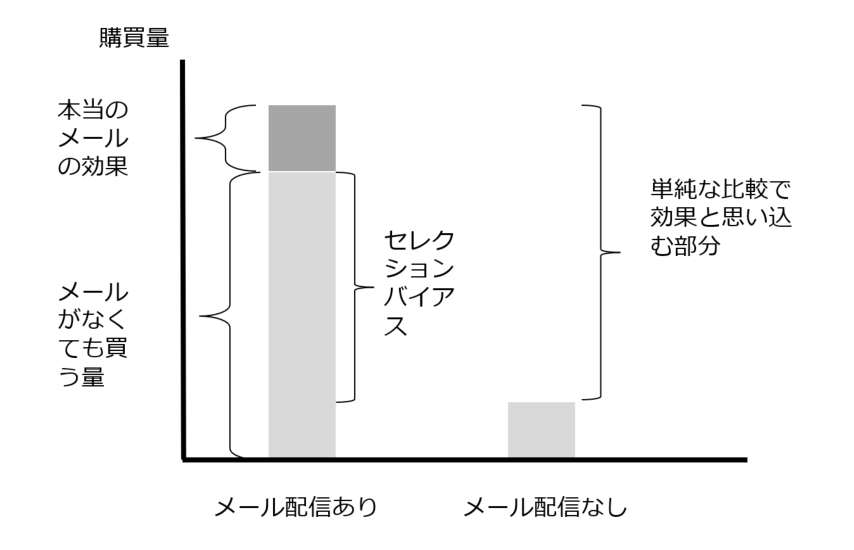

図：セレクションバイアスを説明する図(参照：安井翔太『効果検証入門』1章)

横軸はメール配信があったグループとメール配信がなかったグループを表しており、縦軸は商品の購入金額を表しています。そして、先程の誤った推論は、この図における単純な比較で効果と思い込む部分を本当のメールの効果としてしまっていることが問題です。

ここにおいて、そもそもメール配信ありとメール配信なしのグループでは共変量の1つである「商品への関心」が全然違うということに気づきます。こういったバイアスを引き起こす変数のことを**交絡変数(Confounder)**と呼びます。日本語だとわかりづらいかもしれませんが、英語でConfoundは混乱させるという意味があるので、混乱させるものということになります。

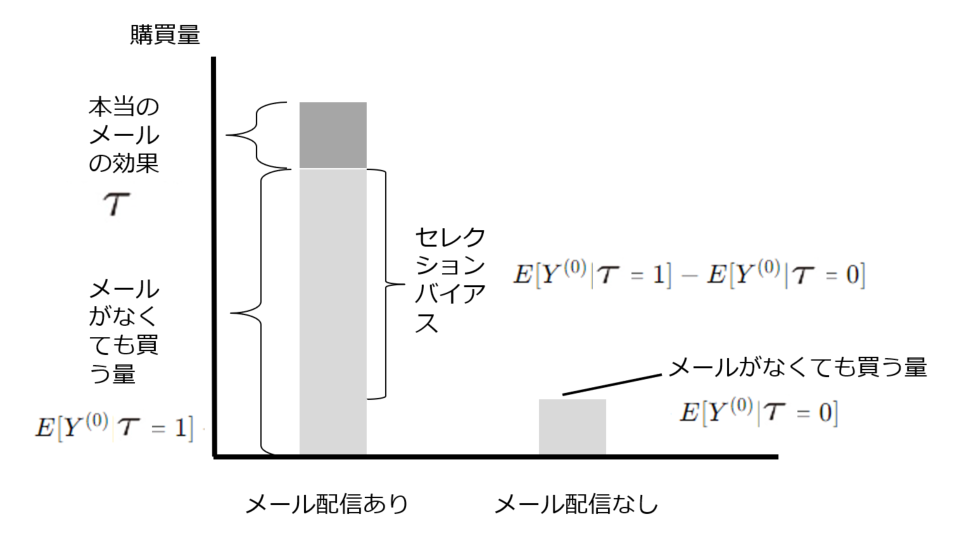

図：セレクションバイアスをポテンシャルアウトカムを用いて表現する図(参照：安井翔太『効果検証入門』1章)

このバイアスを数式で表現すると以下のようになります。

そもそも私達が知りたい母集団における量、つまり推定対象（Estimand）は以下のものです。

$$
E[Y(1) - Y(0)]
$$

これは、アウトカムY(1)と処置を受けていない場合のアウトカムY(0)の差の期待値であり、**平均処置効果(Average Treatment Effect, ATE)**というものです。

これを推定するためには、サンプルにおいて以下の値を求めるのが良いでしょう。

$$
\frac{1}{n} \sum_{i = 1}^{n} \big [ Y_i(1)-Y_i(0) \big ]
$$

これは、すべての個人について処置を受けた場合のアウトカムY(1)と処置を受けていない場合のアウトカムY(0)の差を求め、その平均を取ったものです。ただ、因果推論の根本問題があるため、この値は手元のサンプルでは計算できません。

そして、単純な差というのは以下の値を計算しています。処置を受けている人の集合を$T$、処置を受けている人の数を$N_T$として、処置を受けていない人の集合を$C$、処置を受けていない人の集合を$N_C$とすると、

$$
\frac{1}{N_T}\sum_{i \in T}Y_i(1) - \frac{1}{N_C}\sum_{i \in C}Y_i(0)
$$
これはつまり、処置を受けた人でのアウトカムの平均と処置を受けていない人でのアウトカムの平均の差を取っています。そして、それが推定しているのは、ATEではなく、以下の値になります。

$$
E[Y|T = 1] - E[Y|T = 0]
$$

一般的にATEとこの値は一致していません。

$$
E[Y(1) - Y(0)] \neq E[Y|T = 1] - E[Y|T = 0]
$$

そのため、バイアスが生じます。

また、ここで登場する$E[Y(1)|T = 1]$のようなものを**条件つき期待値**といいます。上の例だと、$E[Y|T = 1]$は処置を受けた人だけに限った$Y$の期待値を表します。

### RCT

では、どうすることでバイアスを取り除くことができるのでしょうか。まず、考えられるのが、**ランダム化比較実験(Randomized Controlled Trial, RCT)**です。


アイデアとしては、上の例ではメアドを登録した人のみにメールが届くようになっていましたが、例えば、そうではなくすべての顧客層からランダムに抽選でメールを送る人を決めます。


そうすることで、商品に強い関心を持つ人だけがメールをもらうということは理論的になくなるので、セレクションバイアスなく因果効果を推定することができます。他のRCTの例としては、薬の効果を検証する際に、ランダムに本当の薬を投与し、その他の人には偽の薬（プラセボ）を投与するというものなどがあります。

しかし、ランダム化比較実験には、実現可能性が低い場合が多々あります。例えば、ランダム化比較実験をやろうにもメールアドレスがわからないなどの技術的な問題や、薬を投与する際に、症状の重い人を優先するべきという倫理的な理由、もしくは、薬が高価でサンプルサイズを十分に集めることができないという場合もあるでしょう。

もしくは、実験の段階から携われず、RCTではない形で既に施策が実施された後のセレクションバイアスがあるデータしか手元にない場合もあるでしょう。そのようなデータをRCTなどの**実験データ（Experimental Data）**に対して、**観察データ（Observatinal Data）**と呼びます。観察データの場合の方法を今回の講座ではいくつか紹介します。

ここで、一度RCTのデータで実装をしながらこれまでの内容を簡単に振り返ってみましょう。

## RCTデータにおける因果推論



では、これまでの内容を実際のデータを使って確認していきましょう。ここでおさえてほしいポイントは、①RCTであれば単純な差を取ることによって因果効果が計算できること、②処置変数だけを変数に入れた回帰分析によって、処置変数の係数を求めることは因果効果を推定することと同じであることの2つです。

### 単純な差

このデータはRCTデータなので、セレクションバイアスは取り除かれていることに注意してください。つまり、単純な差を取ることで因果効果を推定することが可能です。

では、まず、下のコードを読み込んでください。

In [1]:
# ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 小数第3位まで表示
%precision 3

'%.3f'

ここでは、先ほどの例と同じようにメールを使ったマーケティングのデータで実装してきます。以下のデータを読み込んでください。

In [2]:
df_email = pd.read_csv('http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv')

In [3]:
df_email.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


上のデータは、左から順に、
* recency:直近購買からの経過月数
* history_segment:昨年の購入セグメント
* **history:昨年の購入金額**
* mens:昨年に男性商品の購入履歴があるかフラグ
* womens:昨年に女性商品の購入履歴があるかフラグ
* zip_code:地区（zipcodeがベース）、都会や郊外など
* newbie:過去12ヶ月以内に新しいユーザーになったかどうかフラグ
* channel:購買チャネル
* **segment:どんなメールが送信されたか（男性、女性、なし）**
* visitメール:配信後2週以内にウェブに訪問したかどうかフラグ
* **conversion:メール配信後2週以内に購買したかどうかフラグ**
* **spend:購入した時の金額**
となります。

さて、まずメール施策を実施したかどうかをわかりやすくするために、データを加工します。

In [4]:
df_email.segment.value_counts()

,count
segment,
Womens E-Mail,21387
Mens E-Mail,21307
No E-Mail,21306


"Womens E-Mail"と"Mens E-Mail" でメール送信フラグを1、"No E-Mail" を0として`flg`カラムを追加します。

In [5]:
df_email['flg'] = df_email["segment"].map(lambda x: 0 if x == "No E-Mail" else 1)
df_email.flg.value_counts()

,count
flg,
1,42694
0,21306


ここで単純な差を求めてみましょう。今、RCTをしているデータであることを思い出すと、セレクションバイアスがないため、因果効果をきちんと求められていることが分かります。

メールを送信したflg=1のグループと送信していないflg=0のグループでやspend（購買金額）に差があるのかを計算してみます。

In [6]:
df_email.groupby("flg")["spend"].mean()

,spend
flg,
0,0.652789
1,1.249585


メールを送信したグループは1.24で、メールを送信していないグループは0.65でこちらも2倍近くの差があり、その効果の差分である1.24-0.65=0.59の因果効果がメールマーケティングにあるといえます。

### 回帰分析による結果の確認

そして、次に回帰分析の結果を見ます。処置があるかを表すflg説明変数として入れてみましょう。このとき、flgの係数は先程の単純な差と変わらないことを数値的に確認してみましょう。

In [7]:
X = sm.add_constant(df_email["flg"])
y = df_email["spend"]

model = sm.OLS(y, X)
result = model.fit()

In [8]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  spend   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     22.40
Date:                Mon, 02 Dec 2024   Prob (F-statistic):           2.22e-06
Time:                        11:07:29   Log-Likelihood:            -2.6427e+05
No. Observations:               64000   AIC:                         5.285e+05
Df Residuals:                   63998   BIC:                         5.286e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6528      0.103      6.338      0.000       0.451       0.855
flg            0.5968      0.126      4.733      0.000       0.350       0.844
==============================================================================
Omnibus:                   141146.894   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        700454501.209
Skew:                          20.585   Prob(JB):                         0.00
Kurtosis:                     513.858   Cond. No.                         3.23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

上の結果から、切片(const)が約0.35️、メール送信有無(flg)の係数が約0.59になっています。そしてt検定は全てp-valueが0.05より小さくなっているため、係数は有意な結果になりました。よって、メール送信の効果したは0.59ほど売り上げをあげる効果があるということがわかり、上の単純な差を計算した場合と同じになっているのがわかります。

ここで少し脇道にそれて、過去の購買金額（history）を回帰式に入れて分析してみましょう。

In [9]:
X = sm.add_constant(df_email[["history","flg"]])
y = df_email["spend"]

model = sm.OLS(y, X)
result = model.fit()

In [10]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  spend   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     26.24
Date:                Mon, 02 Dec 2024   Prob (F-statistic):           4.07e-12
Time:                        11:07:30   Log-Likelihood:            -2.6426e+05
No. Observations:               64000   AIC:                         5.285e+05
Df Residuals:                   63997   BIC:                         5.285e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3464      0.117      2.957      0.003       0.117       0.576
history        0.0013      0.000      5.484      0.000       0.001       0.002
flg            0.5945      0.126      4.715      0.000       0.347       0.842
==============================================================================
Omnibus:                   141122.328   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        699656310.293
Skew:                          20.576   Prob(JB):                         0.00
Kurtosis:                     513.566   Cond. No.                         946.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

historyの係数が0.0013になっていますね。本来は、過去の購買金額は今の購買金額に対して強く関連していそうな変数ですが、今の例では、係数がほとんど0に近いような値になっています。
これはまさにRCTによるものであり、過去の購買金額の影響がランダム化によって取り除くことができている例になります。

まとめると、ここではRCTデータにおいて単純な差で因果効果を推定できること、それとトリートメントだけを入れた回帰分析は数値的に同等であることを確認できました。

次の章でも、単純に差を計算するのではなく、回帰分析によって分析を進めていきます。

## 回帰分析による交絡変数のコントロール

先程の実装のメールマーケティングのデータはRCTデータであるからこそ回帰分析で単純な差を求めることによりうまく因果効果を推定することができましたできました。

ここでは、①観察データでは単純な回帰分析ではセレクションバイアスが入ってしまうこと、②交絡変数を入れた回帰分析によってセレクションバイアスを取り除けることを確認していきます。


### セレクションバイアス

ここでは、就労支援が収入にもたらす因果効果を推定することを目標にしましょう。用いるデータは、1970年代のアメリカで行われたNational Support Work(NSW)というプログラムのものであり、条件を満たす希望者にランダムに就労支援を実施したデータです。

このデータセットの特徴としては、実験データも観察データもあるということです。そのため、観察データから求めた因果効果がどれほど実験データから求めた因果効果に近いかでバイアスのかかっている程度を確認することができます。

まず、RCTのデータから見ていきましょう。この結果をひとまず正しい因果効果として、後の分析がいかにバイアスがかかっているのかをしていきましょう。

In [11]:
#就労支援プログラムRCTデータ
df_nsw_rct = pd.read_stata('https://users.nber.org/~rdehejia/data/nsw_dw.dta')
df_nsw_rct.head()

,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,Dehejia-Wahba Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.045898
1,Dehejia-Wahba Sample,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.894043
2,Dehejia-Wahba Sample,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.449219
3,Dehejia-Wahba Sample,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.145996
4,Dehejia-Wahba Sample,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.789886


コラムは左から、

- treat(処置を受けたならば1, 受けていないならば0)
- age
- education
- Black(黒人であれば1、そうでなければ0)
- Hispanic(ヒスパニックであれば1、そうでなければ0)
- married(結婚していれば1、そうでなければ0)
- nondegree(学位を持っていなければ1、そうでなければ0)
- re74 (1974年の収入)
- re75 (1975年の収入)
- re78 (1978年の収入)

となります。就労支援プログラムを受けた後の収入が1978年の収入であり、共変量として、1974年・1975年の収入、他に年齢・教育年数・人種などの背景属性も含まれています。


では、RCTデータにおける因果効果を推定してみましょう。先程の実装と同様に、処置を受けた群と処置を受けていない群の単純な差を求めます。

In [12]:
X = sm.add_constant(df_nsw_rct[["treat"]])
y = df_nsw_rct["re78"]

model = sm.OLS(y, X)
result = model.fit()

In [13]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   re78   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     8.039
Date:                Mon, 02 Dec 2024   Prob (F-statistic):            0.00479
Time:                        11:07:30   Log-Likelihood:                -4542.7
No. Observations:                 445   AIC:                             9089.
Df Residuals:                     443   BIC:                             9098.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4554.8011    408.046     11.162      0.000    3752.855    5356.747
treat       1794.3424    632.853      2.835      0.005     550.574    3038.110
==============================================================================
Omnibus:                      282.071   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3430.892
Skew:                           2.547   Prob(JB):                         0.00
Kurtosis:                      15.613   Cond. No.                         2.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

よって、treatの係数を確認すると、因果効果は1794程度であることが分かります。

では、セレクションバイアスがかかっていると思われる観察データの方を確認していきます。

In [14]:
# RCTでないデータ
# 観察データ（Observatinal Data）
cps3_data = pd.read_stata("https://users.nber.org/~rdehejia/data/cps_controls3.dta")
df_nsw_obs = pd.concat( [df_nsw_rct.query("treat==1"), cps3_data], axis=0)

df_nsw_obs.head()

,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,Dehejia-Wahba Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.045898
1,Dehejia-Wahba Sample,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.894043
2,Dehejia-Wahba Sample,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.449219
3,Dehejia-Wahba Sample,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.145996
4,Dehejia-Wahba Sample,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.789886


コラムはRCTのデータと全く同じです。
では、先ほどと同様に処置変数だけを入れて分析してみましょう。

In [15]:
X = sm.add_constant(df_nsw_obs[['treat']])
y = df_nsw_obs["re78"]

model = sm.OLS(y, X)
result = model.fit()

In [16]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   re78   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9339
Date:                Mon, 02 Dec 2024   Prob (F-statistic):              0.334
Time:                        11:07:31   Log-Likelihood:                -6346.4
No. Observations:                 614   AIC:                         1.270e+04
Df Residuals:                     612   BIC:                         1.271e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6984.1698    360.710     19.362      0.000    6275.791    7692.549
treat       -635.0263    657.137     -0.966      0.334   -1925.544     655.492
==============================================================================
Omnibus:                      209.619   Durbin-Watson:                   1.809
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              775.566
Skew:                           1.567   Prob(JB):                    3.87e-169
Kurtosis:                       7.527   Cond. No.                         2.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

ここで、treatの係数は-635.0263という負の値であり、これでは処置効果がマイナス、つまり、就業訓練をしたら収入が下がってしまうというおかしな結果になっています。さらに、t検定も有意ではないという結果が出てしまっています。


これは観察データにあるセレクションバイアスによるものと考えられます。


例えば、職業訓練を受ける人は、もともと教育年数が低い、もしくは、学位を持っていない傾向にあり、職についた後の収入がそこまで高くない可能性が考えられます。つまり、そもそも既に職に就いている人は、職業訓練を受けなければならない人よりも、よい収入をもらっているというバイアスが考えられます。

### 交絡変数を入れた回帰分析

こういったバイアスが掛かっている場合、交絡変数がある場合にどのようにすれば回帰分析でバイアスなく因果効果を推定することができるでしょうか。

結論から言うと、処置にもアウトカムにも影響を与える変数である交絡変数を回帰式に入れることでバイアスを取り除くことができます。

式で書くと、
- アウトカム：$Y$
- 処置変数：$T$
- 交絡変数（共変量）：$X$
- 誤差項：u
を用いて以下のように書けます。

$$
Y = \beta_0 + \beta_1T + \beta_2X + u
$$

このように回帰式に$X$を追加することを、Xの影響をコントロールすると言います。詳細な説明は省きますが、ざっくり言うと、Xによる影響を$\beta_2$が吸収しているというイメージです。

では、交絡変数としてデータセットにあるすべての変数を入れてみましょう。（本来その変数を本当にコントロールするべきかの基準があり、それは補足で触れます。）

In [17]:
# 交絡変数をコントロール変数として追加
X = sm.add_constant(df_nsw_obs[['treat','age', 'education', 'black', 'hispanic', 'married', 'nodegree', 're74', 're75']])
y = df_nsw_obs["re78"]

model = sm.OLS(y, X)
result = model.fit()

In [18]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   re78   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     11.64
Date:                Mon, 02 Dec 2024   Prob (F-statistic):           5.99e-17
Time:                        11:07:31   Log-Likelihood:                -6297.8
No. Observations:                 614   AIC:                         1.262e+04
Df Residuals:                     604   BIC:                         1.266e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         66.5145   2436.746      0.027      0.978   -4719.009    4852.038
treat       1548.2438    781.279      1.982      0.048      13.890    3082.598
age           12.9776     32.489      0.399      0.690     -50.827      76.783
education    403.9412    158.906      2.542      0.011      91.865     716.017
black      -1240.6441    768.764     -1.614      0.107   -2750.420     269.132
hispanic     498.8968    941.943      0.530      0.597   -1350.984    2348.777
married      406.6208    695.472      0.585      0.559    -959.217    1772.458
nodegree     259.8174    847.442      0.307      0.759   -1404.474    1924.108
re74           0.2964      0.058      5.086      0.000       0.182       0.411
re75           0.2315      0.105      2.213      0.027       0.026       0.437
==============================================================================
Omnibus:                      216.123   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1182.664
Skew:                           1.467   Prob(JB):                    1.54e-257
Kurtosis:                       9.134   Cond. No.                     7.64e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.64e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

結果を見ると、treatの係数は1548となり、RCTによる結果の1794にかなり近づいたことが分かりました。一つ注意点として、この分析では、他の係数が因果効果を表しているわけではないという点です。例えば、ageの係数は12ですが、年齢が上がることと収入が上がることには因果効果とは解釈できません。それは、今のケースでは、就労支援という政策だけが処置の仮定を満たしているためです。

また、ここから政策に対してわかることとしては、前のバイアスのかかった分析ではtreatの係数は-635であったため、効果がないと判断されており、ここからこの政策は不要だと誤って判断されていたかもしれませんが、この分析から、treatの係数は1548と出ており、信頼区間も0を跨いではいないので、正しい政策判断ができていると解釈できます。この点は、最終課題の企業の施策などにも応用できます。

また、例えば、ここから、最終課題のような提案をするためには、この施策の費用を計算して、それに見合った政策の効果が得られるのかを計算するなどができると思います。

今の場合であれば、政策であるため「見合った効果」を定義するのは難しいですが、最終課題は企業の施策について考えることになるため、費用よりも利益が出るのかを試算することができます。

なお、結果が実験データの場合と完全に一致していないのは、サンプルサイズが小さく推定量の分散がかなり大きいという理由もありますが、まだ欠落している交絡変数、もしくは、観測ができない交絡変数によるというのも考えられます。例えば、仕事に対する意欲などはデータとして得るのは難しそうな交絡変数です。

観測不能な交絡変数がある可能性に対して、因果効果がそれでも妥当だときちんとサポートするための方法として、感度分析（Sensitivity Analysis）というものがあります。これは少し高度な内容ですので、関心のある方は金本(2024)『因果推論』第6章を参照してみてください。

## 補足：因果推論に必要な仮定

今回は数理的な議論を省いたため、きちんと触れることができなかった因果推論の仮定について紹介します。これらの仮定は複数の名前がついています。

#### **1.非交絡(Unconfoundedness)**

条件付き独立性Conditional Independence、無視可能性Ignorabilityなどの名称でも呼ばれます。

$$
Y(1), Y(0) \mathop{\perp\!\!\!\!\perp} T | X
$$

この$\mathop{\perp\!\!\!\!\perp}$という記号は、確率変数の独立性を意味していて、後ろに$|X$とついているのは、Xがで条件づけたときの独立性を表しています。

これが意味することは、共変量が同じ人のグループであれば、処置とアウトカムの間に未観測の交絡変数がないということです。

メールマーケティングの例だと、年齢・性別・昨年度の商品購入額などをコントロールすれば、つまり、年齢・性別・昨年度の商品購入額などが同じ人で比較したとき、バイアスはかからないということを仮定しています。

先ほど紹介した感度分析はこの仮定が本当に成り立っているのかを確認する分析と言えます。

また、RCTができているときには、条件付き独立性より強い以下の仮定が成り立ちます。

$$
Y(1), Y(0) \mathop{\perp\!\!\!\!\perp} T
$$

#### **2.一致性(Consistency)**

SUTVA(Stable Unit Treatment Assignment)とも呼ばれるときもあります。

$$
Y_i = T_iY_i(1) + (1 - T_i)Y_i(0)
$$

これは、処置を受けたときの確率変数YがポテンシャルアウトカムY(1)と一致するという仮定です。

当たり前のように思えますが、これは以下の2つの内容を含意しています。文献によって指示しているがことなることがありますが、いずれにせよ以下の2点は重要なポイントです。

1. 処置がきちんと定義されていること
2. 処置に波及効果（Spillover）がない


1つ目に関しては、例えば、「ダイエットをする」という処置はきちんと定義されているとは言えません。

「ダイエットをする」というのは、ランニングをするということでしょうか、もしくは、炭水化物を抜くということでしょうか。さらに、「ダイエットをしない」というのは、1日中座っていることでしょうか、お菓子をたくさん食べるということでしょうか。

といったように、なんとなく「ダイエットをする」というのを考えるだけでは良い比較はできません。そのため、例えば、「ランニングする人」と「通勤・通学で少し歩くだけの人」の比較であるといったように処置を定義して、効果検証に説得力を持たせられるようにしましょう。

2つ目に関しては、例えば、感染予防効果のあるワクチンの効果を調べるというのは、処置に波及効果がある例になります。というのも、例えば、学校であるクラスのAさんがワクチンを受けなくとも、Aさん以外のクラスメイト全員がワクチンを受ければ、Aさんが感染する確率はかなり下がります。こういった場合、ポテンシャルアウトカムをうまく考えることができないため、因果効果の推定が格段に難しくなります。

メールマーケティングであれば、Aさんの購入金額に関係するのは、Aさんがメールを受け取ったか否かであり、Aさんの隣人のBさんがメールを受け取ったからといって、Aさんが商品を買いたくなるかといったら、そうとは限りませんよね。なので、この場合では、仮定は満たされているということになります。

#### **3.重なりの仮定(Overlap, Positivity)**

$$
0 < P(T = 1 | X) < 1
$$

この不等式が任意の共変量Xについて成り立つというのが、重なりの仮定になります。

この仮定の解釈としては、どのような属性を持っている人についても、処置を受ける人と受けない人がいるということです。

例えば、処置群には20代のデータがあるにも関わらず、対照群には20代のデータがなかった場合、同じ条件で比較することが難しく、因果効果にバイアスがかかってしまいます。また、対照群に20代のデータが無いわけではないが少なかった場合にも、バイアスが生じてしまいます。

## 補足：重なりの仮定が満たされていない場合

さて、先程紹介した3つの仮定が満たされなかった場合はどうなるのでしょうか。

非交絡の仮定が満たされていない場合は、すでに見たようにセレクションバイアスなどのバイアスがかかってしまいます。対策として、コントロール変数を用いることができます。

一致性の仮定が満たされていない場合は、数値上問題はないかもしれませんが、分析結果の解釈がおかしくなってしまいます。対策として、処置をきちんと波及効果なく定義して、そのデータを入手する必要があります。

重なりの仮定に関しては、処置群と対照群で共変量が似ているかどうかを確かめる必要があります。ここでは、このチェック怠ってしまった場合にどうなるのかを確認しましょう。

先程の就労支援プログラムのデータは対照群のデータが複数用意されています。就労支援プログラムを受けている人は限られますが、受けていない人はデータを取りやすいためです。

In [19]:
# RCTでないデータ
# 観察データ（Observatinal Data）

cps1_data = pd.read_stata("https://users.nber.org/~rdehejia/data/cps_controls.dta")
df_nsw_obs = pd.concat( [df_nsw_rct.query("treat==1"), cps1_data], axis=0)

df_nsw_obs.head()

,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,Dehejia-Wahba Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.045898
1,Dehejia-Wahba Sample,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.894043
2,Dehejia-Wahba Sample,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.449219
3,Dehejia-Wahba Sample,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.145996
4,Dehejia-Wahba Sample,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.789886


In [20]:
df_nsw_obs["treat"].value_counts()

,count
treat,
0.0,15992
1.0,185


まず、処置群と対照群のサンプルサイズが大きく違うことが分かります。では、年齢・教育年数・75年の賃金の分布が処置群と対照群でどこまで違うのか確認してみましょう。



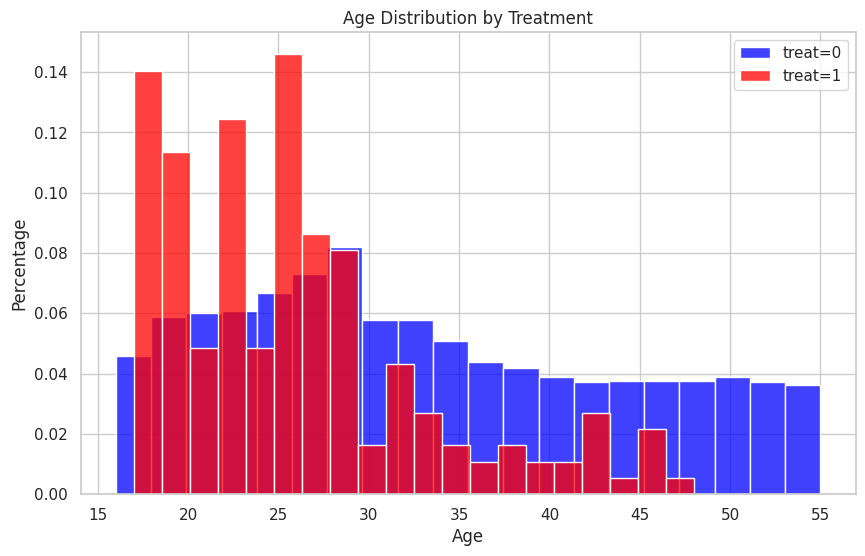

In [21]:
import seaborn as sns
sns.set(style="whitegrid")

treat_0 = df_nsw_obs[df_nsw_obs['treat'] == 0]
treat_1 = df_nsw_obs[df_nsw_obs['treat'] == 1]
total_samples = len(df_nsw_obs)

plt.figure(figsize=(10, 6))
sns.histplot(treat_0['age'], color='blue', label='treat=0', stat='probability', bins=20)
sns.histplot(treat_1['age'], color='red', label='treat=1', stat='probability', bins=20)

plt.title('Age Distribution by Treatment')
plt.xlabel('Age')
plt.ylabel('Percentage')

plt.legend()
plt.show()

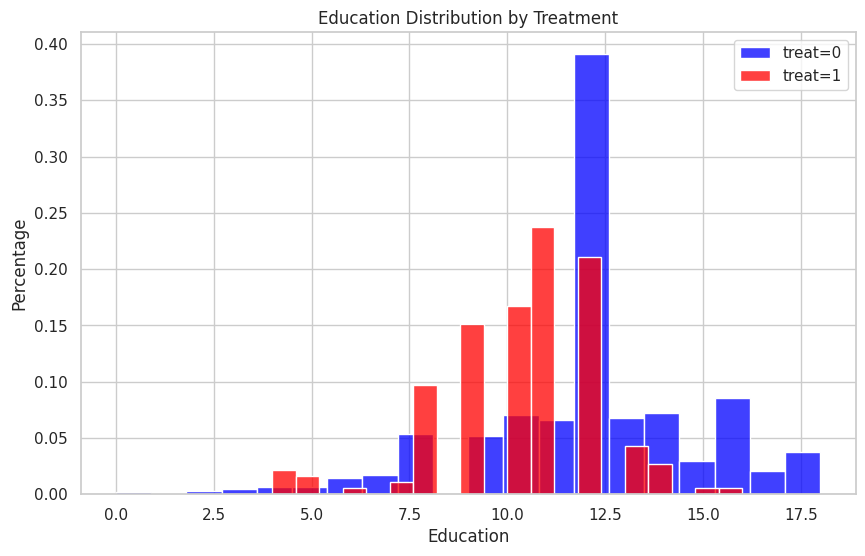

In [22]:
sns.set(style="whitegrid")

treat_0 = df_nsw_obs[df_nsw_obs['treat'] == 0]
treat_1 = df_nsw_obs[df_nsw_obs['treat'] == 1]
total_samples = len(df_nsw_obs)

plt.figure(figsize=(10, 6))
sns.histplot(treat_0['education'], color='blue', label='treat=0', stat='probability', bins=20)
sns.histplot(treat_1['education'], color='red', label='treat=1', stat='probability', bins=20)

plt.title('Education Distribution by Treatment')
plt.xlabel('Education')
plt.ylabel('Percentage')

plt.legend()
plt.show()

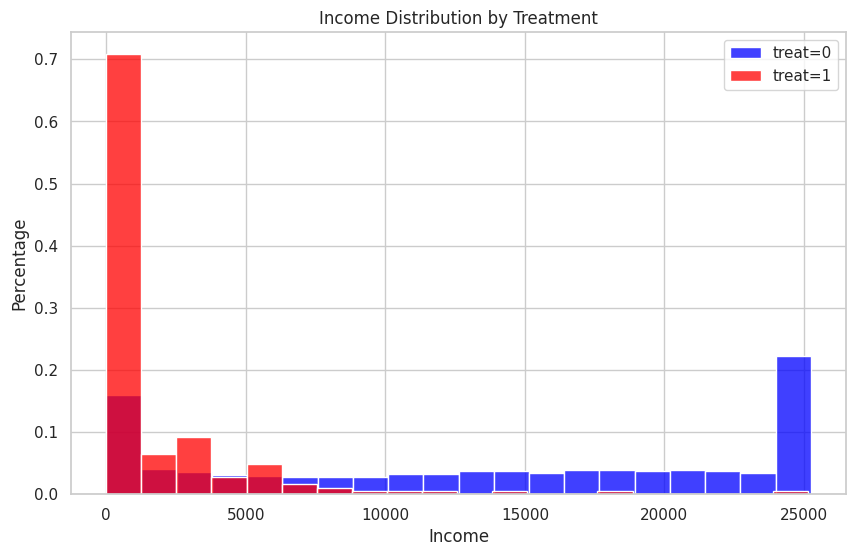

In [23]:
sns.set(style="whitegrid")

treat_0 = df_nsw_obs[df_nsw_obs['treat'] == 0]
treat_1 = df_nsw_obs[df_nsw_obs['treat'] == 1]
total_samples = len(df_nsw_obs)

plt.figure(figsize=(10, 6))
sns.histplot(treat_0['re75'], color='blue', label='treat=0', stat='probability', bins=20)
sns.histplot(treat_1['re75'], color='red', label='treat=1', stat='probability', bins=20)

plt.title('Income Distribution by Treatment')
plt.xlabel('Income')
plt.ylabel('Percentage')

plt.legend()
plt.show()

どの変数も大幅に分布が違うことが分かりますね。

この場合、先程と同様に交絡変数をコントロールしたとしても、結果は以下のようになります。

In [24]:
X = sm.add_constant(df_nsw_obs[['treat','age', 'education', 'black', 'hispanic', 'married', 'nodegree', 're74', 're75']])
y = df_nsw_obs["re78"]

model = sm.OLS(y, X)
result = model.fit()

In [25]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   re78   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     1631.
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        11:07:40   Log-Likelihood:            -1.6618e+05
No. Observations:               16177   AIC:                         3.324e+05
Df Residuals:                   16167   BIC:                         3.325e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5735.7312    445.176     12.884      0.000    4863.138    6608.325
treat        699.1317    547.636      1.277      0.202    -374.296    1772.559
age         -101.8551      5.881    -17.320      0.000    -113.382     -90.328
education    160.1864     28.594      5.602      0.000     104.139     216.234
black       -836.9473    212.826     -3.933      0.000   -1254.109    -419.786
hispanic    -218.3184    218.663     -0.998      0.318    -646.923     210.286
married       73.0758    142.409      0.513      0.608    -206.061     352.212
nodegree     372.2376    177.590      2.096      0.036      24.141     720.334
re74           0.2895      0.012     23.953      0.000       0.266       0.313
re75           0.4707      0.012     38.697      0.000       0.447       0.495
==============================================================================
Omnibus:                     1536.524   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3028.407
Skew:                          -0.632   Prob(JB):                         0.00
Kurtosis:                       4.701   Cond. No.                     2.33e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.33e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Treatの係数が699であり、結果にかなりのバイアスがかかっていることが分かりました。

この対策として、後に紹介する傾向スコアを用いた逆確率重み付け法（Inversed Probability Weighting）やそれを拡張したAIPW（Augmented Inverse Probability Weighting）、もしくは、直接的に共変量をバランスさせることを目指すBalancing Weightなどの手法が研究されています。

ここでは紹介しきれないので、関心のある方は、安井翔太『効果検証入門』3章や金本拓(2024)『因果推論』3.3などを参照してみてください。

## 補足：Post-treatmentバイアスに注意

これまでの説明から交絡変数となる共変量を回帰式に入れることによってバイアスを除けるということが分かりました。しかし、なんでも関係ありそうなものを入れればよいというわけではないです。

その一例として、処置後の変数を説明変数に入れると発生するPost-treatmentバイアスというものがあります。

先ほどのメールマーケティングのデータで、本来は処置後に分かる変数である、conversion(メール配信後2週以内に購買したかどうか)を共変量に入れてしまった場合どうなるのかを確認しましょう。

In [26]:
X = sm.add_constant(df_email[["conversion","flg"]])
y = df_email["spend"]

model = sm.OLS(y, X)
result = model.fit()

In [27]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  spend   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                 3.696e+04
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        11:07:40   Log-Likelihood:            -2.3971e+05
No. Observations:               64000   AIC:                         4.794e+05
Df Residuals:                   63997   BIC:                         4.795e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0135      0.070     -0.192      0.847      -0.151       0.124
conversion   116.3611      0.428    271.803      0.000     115.522     117.200
flg            0.0203      0.086      0.236      0.813      -0.148       0.189
==============================================================================
Omnibus:                   135989.254   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1117174138.664
Skew:                          18.482   Prob(JB):                         0.00
Kurtosis:                     649.200   Cond. No.                         13.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

flgの係数の値が0.02になってしまい、強いバイアスがかかっていることが分かります。そのため、コントロールすべき変数は、処置の前に事前に分かる変数ということが分かります。

こういった変数を体系的に判別するために、非巡回有向グラフ（Directed Acyclic Graph: DAG）によって変数間の関係を表現するという方法があります。これも、関心のある方は、金本拓(2024)『因果推論』2.5を参照してみてください。

# 2. 機械学習を用いた因果推論

ここまでで因果推論の基本をカバーしました。ここから様々な因果推論の手法の勉強を始めることができると思います。

操作変数法や回帰不連続デザイン、差の差法などといったような、現実にある設定・自然実験を活用した手法もありますが、ここでは、この講座の趣旨にも沿って、機械学習を用いた応用的な因果推論の話をしていきます。

時間の都合もあり、要点だけの簡潔な説明になっているので、関心のある方は、金本拓『因果推論』4,5章や、齋藤優太『反実仮想的機械学習』をぜひ読んでみてください。

## なぜ因果推論に機械学習が必要か

### 因果推論とは欠損値の予測である

まず、簡単な復習から始めます。セレクションバイアスを考えると、最も理想的な検証方法とは、**「まったく同じ中身のサンプルで比較する」**という方法です。ですが、残念ながらそれは不可能です。例えば、ある人のメールを送った後の反応を観察し、そして、全く同じ人のメールを送らなかった場合の反応も観察するというのはできません。

当たり前のことですが、現実に起こっていない場合のことは観察できないため、これによって、全くバイアスのかかっていない因果推論というのは実現できないということが分かります。これを**「因果推論の根本問題**」といいます。





もちろん、それで諦めるわけにはいきません。メールを送っていない場合の反応は観察できないかもしれませんが、他の似たケースから**予測**することは可能です。

例えば、メールが配信された人をAさんとします。さらに、Aさんは「20代・男性・学生」という属性を持っていて、商品の購入額が1000円だとしましょう。そこで、メールが配信されていない人において「20代・男性・学生」という属性を持っているBさんがいて、購入額が600円であれば、その値をAさんが仮にメールを受け取っていなかったとした場合の売上の予測値とすることができます。

これはとても単純なケースですが、データの数や変数が多いもっと複雑なケースでは**機械学習**による予測の力を借りる必要があるでしょう。

### 機械学習 vs 線形回帰

機械学習が予測に向いていると言っても、回帰分析でも予測をすることは可能であるではないかと思った方もいるかもしれません。実際に、前の節では回帰分析で因果推論をすることができていました。

それでもなお、機械学習を使うメリットとしては、十分に大きいサンプルサイズのもとで、モデルの**誤特定（Misspecification）**を回避することができるためです。

モデルの誤特定とは、線形回帰の例で言うと、変数の本来の関係が線形ではない関係であるときに、線形回帰で分析するようなこと、つまり、モデリングの時点で線形だとしているのが誤りだということです。

それでも交互作用項や二次項で対策することも可能だと思われるかもしれませんが、それだと、どの変数で交互作用項を作るのか、どの変数を二次項とするのかを決めなければいけません。変数が何百とある状況だと、これを分析者がやるのは至難の技です。

その際に、機械学習を使用することで、あらかじめ分析者が特定のモデルの形を決めずに、機械学習に決めてもらうことができるので、誤特定にも対応することができます。

しかし、だからといって機械学習だけを使えば良いということではありません。機械学習の大きなデメリットとしてきちんとした分析をするには大きなサンプルサイズが必要であるということが挙げられます。また、回帰分析のように簡単に信頼区間を作ったり検定をしたりすることができないため、機械学習と回帰分析で状況に合わせた使い分けが大切になります。

## 因果効果の異質性

この節が前節と違う点として、推定対象がATEではないという点があります。

これまでの手法ではATEだけを扱ってきました。ATEを推定するということは、各個人についての因果効果を平均したものを推定するということですが、現実ではこれだけでは情報量が少ないという場合がしばしばです。

例えば、マーケティング戦略として試用品を配ることに平均的に（ATEの意味で）効果があったということがわかったとします。それは過去の施策効果評価としては十分かもしれませんが、今後の施策を考えるにあたっては不十分です。というのも、例えば、効果があるからと言って、顧客全員に試用品を配るというのは難しく、どこかにターゲットを絞り効率的なマーケティングをするというのが、予算などの都合上現実的な判断になるためです。

属性ごとに効果がどのように違うのかを知ることができれば、それによって、因果効果が最も大きくなるグループに絞った施策を考えることができます。

そのために、推定するターゲットとしてATEに代わるものとして、条件つき平均因果効果(Conditonal Average Treatment Effect, CATE)を紹介します。ある属性$X$(確率変数)が$x$(実現値)であるグループのCATEは、

$$
\tau(x) = E[Y(1)|X = x] - E[Y(0)|X = x]
$$

と表されます。例えば$X$が性別であれば、男性と女性に対するCATEは以下のようになります。

$$
\tau(male) = E[Y(1)|X = male] - E[Y(0)|X = male] \\
\tau(female) = E[Y(1)|X = female] - E[Y(0)|X = female]
$$

ここからは、より現実的なマーケティングのシチュエーション(最終課題のシチュエーション)に合わせて、CATEをターゲットにしていきます。



## メタラーナー（Meta-Learner）

機械学習を用いて因果効果の異質性に対応した手法として、ここでは、**メタラーナー(Meta-Learner)**を紹介します。メタラーナーは、複数の機械学習モデル(Base Learners)を組み合わせて因果効果を推定する手法の1つです。Meta-Learnerの中でもいろいろと種類はありますが、基本的なものとして、S-Learner・T-Learnerの2つを解説し、X-Learnerを最後に補足として紹介します。


### S-learnerとT-learner

S-learnerとT-learnerでは、単純に、$X=x$のグループについて、処置を受けた人は処置を受けていない場合のアウトカムを、処置を受けていない人は処置を受けた場合のアウトカムを予測します。

違いとしては、S-learnerは処置群と対照群を1つのモデル$E[Y|X,T]$で推定しますが、T-learnerは処置群と対照群について$E_{t}[Y(1)|X]$、$E_{c}[Y(0)|X]$とそれぞれのモデルで推定します。

そのため、それぞれの推定対象を式で書くと、

$$
\tau_s(x) = E[Y(1)|X=x,T=1] - E[Y(0)|X=x,T=0] \\
\tau_t(x) = E_{t}[Y(1)|X=x] - E_{c}[Y(0)|X]
$$

となります。


では、早速実装してみましょう。なお、以下紹介するコードは、Pythonでメタラーナーを簡単に実装できるライブラリeconmlの[公式ドキュメント](https://github.com/py-why/EconML/blob/main/notebooks/Metalearners%20Examples.ipynb)から引用してきたものです。こちらのコードに手を加えたものが、金本拓(2024)『因果推論』第5章でも説明されており、本教材の解説はそちらも参照しているため、関心のある方はぜひ確認してみてください。

まず、メタラーナーの実装で使うライブラリをインポートしておきましょう。機械学習による因果推論で用いるライブラリ"econml"はインストールする必要があります。

In [28]:
#econmlのインストール
!pip install econml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 15.4 MB/s eta 0:00:00
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.8
    Uninstalling slicer-0.0.8:
      Successfully uninstalled slicer-0.0.8
  Attempting uninstall: shap
    Found existing installation: shap 0.46.0
    Uninstalling shap-0.46.0:
      Successfully uninstalled shap-0.46.0


In [29]:
# メインのライブラリ
from econml.metalearners import TLearner, SLearner, XLearner

# サブで使うライブラリ
from numpy.random import binomial, multivariate_normal, normal, uniform
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor

%matplotlib inline

次にデータを生成するための関数を定義します。

In [30]:
# データ生成過程(Data Generating Process, DGP)を定義する
def generate_data(n, d, controls_outcome, treatment_effect, propensity):
    """
    パラメータ
    ----------
        n (int): サンプルサイズ
        d (int): 共変量の数
        controls_outcome (func): 共変量で条件づけたときの処置を受けていないときのアウトカム（の関数）、ベースライン
        treatment_effect (func): 共変量で条件づけたときの処置効果（の関数）
        propensity (func): 共変量で条件づけたときの傾向スコア（の関数）
    ----------
    これらの条件を満たすようなデータを生成する
    """

    # 共変量
    X = multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n)
    # 処置
    T = np.apply_along_axis(lambda x: binomial(1, propensity(x), 1)[0], 1, X)
    # アウトカム
    Y0 = np.apply_along_axis(lambda x: controls_outcome(x), 1, X)
    treat_effect = np.apply_along_axis(lambda x: treatment_effect(x), 1, X)

    Y = Y0 + treat_effect * T
    return (Y, T, X)

以下では、先程定義したデータ生成のための関数に代入する関数を定義しています。

- まず、共変量の種類を5種類とし、次にサンプルサイズは100としています。

- 次に定義するのはベースライン(controls outcome)です。ベースラインとは、処置を受けていない場合のアウトカム$Y(0)$のことで、例えば、メールを貰わなくても商品を購入する額を指します。ここでは、共変量ごとに、ベースラインを、-3から3の間でランダムに取るようにしています。そして、正規分布からのノイズも加えています。

- 処置効果(treatment effect)は、1つ目の共変量$x[1]$が0.1より大きい場合には8、それ以外の場合には0としています。

- そして、ここで**傾向スコア(propensity score)**という新しい値を導入しています。これは、$P(T_i=1|X_i)$と表されるもので、ある共変量を持つ人の処置を受ける確率を表します。例えば、$P(T_i=1|X_i=male)$であれば、男性が処置を受ける確率となります。今、2つ目の共変量$x[2]$が-0.5から0.5の間にある場合には0.8、$x[2]$がそれ以外の場合には0.2としています。

In [31]:
# 共変量の種類
d = 5

# サンプルサイズ
n = 1000

# ベースライン（controls outcome）
def generate_controls_outcome(d):
    beta = uniform(-3, 3, d)
    return lambda x: np.dot(x, beta) + normal(0, 1)

controls_outcome = generate_controls_outcome(d)

# 処置効果（treatment effect）
treatment_effect = lambda x: (1 if x[1] > 0.1 else 0)*8

# 傾向スコア(propensity score)
propensity = lambda x: (0.8 if (x[2]>-0.5 and x[2]<0.5) else 0.2)

In [32]:
# 上の条件でデータを生成
Y, T, X = generate_data(n, d, controls_outcome, treatment_effect, propensity)

次に、テストデータを生成します。既に定義してあるベースライン・共変量と同じ設定で作ります。X_testが特定の値に偏らないようにするために、-3から3の間を6/250の間隔で出力するようにしています。これによって、250の値で予測精度を確かめることができます。

In [33]:
# テストデータの生成
n_test = 250

# ベースライン（上と同じもの）
controls_outcome = generate_controls_outcome(d)

# 共変量
X_test = multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n_test)
delta = 6/n_test
X_test[:, 1] = np.arange(-3, 3, delta)

では、データが整ったので、S-learnerを実装してみましょう。まず、先程インポートしたsklearnのGradientBoostingRegressorを用いて、S-learnerのインスタンスを作成します。ここでモデルを1つだけ指定するのがS-learnerの特徴でした。そして、訓練データで学習させてテストデータで因果効果を推定します。

In [34]:
# S-learnerのインスタンスを作成する
overall_model = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
S_learner = SLearner(overall_model=overall_model)
# S-learnerを学習させる
S_learner.fit(Y, T, X=X)
# テストデータで因果効果を推定する
S_te = S_learner.effect(X_test)

次に、T-learnerも実装してみましょう。T-learnerはモデルを2つ用意する必要があります。ここでは、同じモデルを使っています。

In [35]:
# T-learnerのインスタンスを作成する
model_1 = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
model_2 = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
T_learner = TLearner(models=(model_1,model_2))
# T-learnerを学習させる
T_learner.fit(Y, T, X=X)
# テストデータで因果効果を推定する
T_te = T_learner.effect(X_test)

S-learnerとT-learnerの結果を見てましょう。

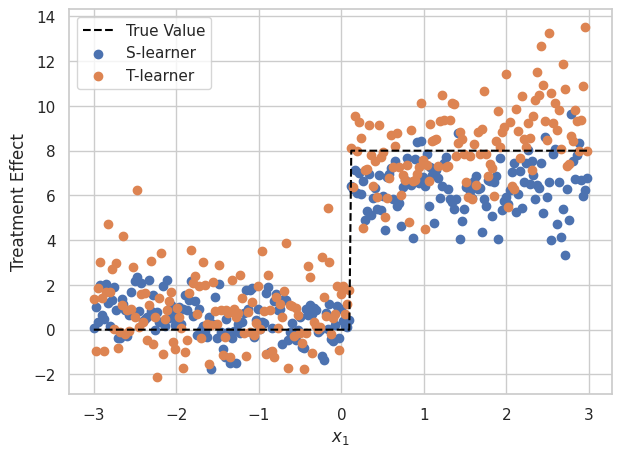

In [36]:
# S-learnerとT-learnerの結果
plt.figure(figsize=(7, 5))
plt.plot(X_test[:, 1], np.apply_along_axis(treatment_effect, 1, X_test), color='black', ls='--', label='True Value')
plt.scatter(X_test[:, 1], S_te, label="S-learner")
plt.scatter(X_test[:, 1], T_te, label="T-learner")
plt.xlabel('$x_1$')
plt.ylabel('Treatment Effect')
plt.legend()
plt.show()

どちらでも概ねTrue Valueに近い値で推定できているのが分かりますね。

一般的に、どのようなアルゴリズムを用いるのか、処置群と対照群のサンプルサイズがどれほどかによって、それぞれの性能が変わってきます。

そのため、例えば、処置群のサンプルでクロスバリデーションを使ってモデルの当てはまりを確かめるなど、これまでの講義で培ってきた内容を活かして応用に挑戦してみましょう！

金本拓『因果推論』の4章・5章を参照することをおすすめします。



### 補足：X-learner

S-learnerとT-learnerの課題として、処置効果にバイアスがかかってしまうということがあります。

このバイアスを取り除く方法の一つとして、補足で紹介した傾向スコアを用いることができます。詳しくは金本拓(2024)『因果推論』第5章の該当箇所を読んでみてください。

X-learnerの実装は以下の通りになります。

In [37]:
# X-learnerのインスタンスを作成する
model_1 = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
model_2 = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
propensity_model = RandomForestClassifier(n_estimators=100, max_depth=6,
                                                  min_samples_leaf=int(n/100))
X_learner = XLearner(models=(model_1,model_2), propensity_model=propensity_model)
# X-learnerを学習させる
X_learner.fit(Y, T, X=X)
# テストデータで因果効果を推定する
X_te = X_learner.effect(X_test)

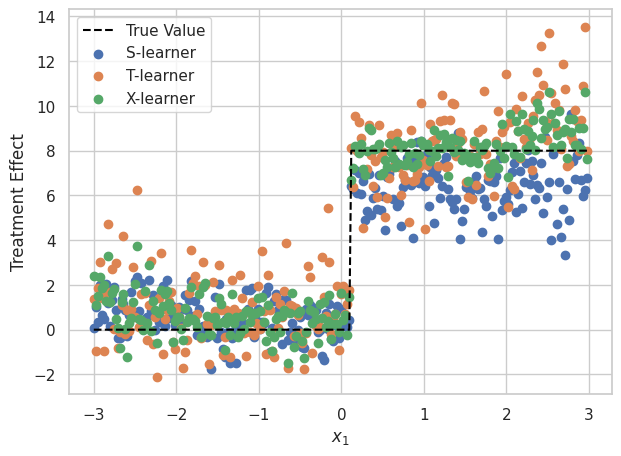

In [38]:
# S-learner,T-learner,X-learnerの結果
plt.figure(figsize=(7, 5))
plt.plot(X_test[:, 1], np.apply_along_axis(treatment_effect, 1, X_test), color='black', ls='--', label='True Value')
plt.scatter(X_test[:, 1], S_te, label="S-learner")
plt.scatter(X_test[:, 1], T_te, label="T-learner")
plt.scatter(X_test[:, 1], X_te, label="X-learner")
plt.xlabel('$x_1$')
plt.ylabel('Treatment Effect')
plt.legend()
plt.show()

X-Learnerの方がバイアスがなく、True-Valueに集中しているのが分かりますね。

# 3. 最終課題に近いケースでの演習

ここでは、上で学んできた機械学習による因果推論を最終課題に近いデータセットにて実装してみます。今回は、講義パートで用いたE_commerce_dataにて実験します。

講義では、「遅延の改善が顧客の満足度向上につながる」という仮説の下、遅延の改善という施策を検討してきました。この施策を行うことに効果があるのか、因果推論を用いてその施策の妥当性を検討します。

今回はS-Learnerを用います。上と同様のimportの方法なので、上で実行していた場合は不要です。

In [39]:
#econmlのインストール
!pip install econml

In [40]:
# メインのライブラリ
from econml.metalearners import TLearner, SLearner, XLearner

# サブで使うライブラリ
from numpy.random import binomial, multivariate_normal, normal, uniform
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor

%matplotlib inline

次にデータを読み込みます。

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
csv_path='/content/drive/MyDrive/Colab Notebooks/E_commerce.csv'#各自の環境に合わせて変更してください
df=pd.read_csv(csv_path)

In [43]:
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Restock_Frequency_Index,Shipment_Frequency_Index
0,1,D,Flight,4,2,177,3,low,F,44,5335,1,0.034091,0.200000
1,2,F,Flight,4,2,216,2,low,M,59,2941,1,0.025424,0.200000
2,3,A,Flight,2,2,183,4,low,M,48,3374,1,0.062500,0.333333
3,4,B,Flight,3,1,176,4,medium,M,10,1149,1,0.300000,0.250000
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1,0.065217,0.333333


今回のリサーチクエスチョンは「商品遅延の改善が、顧客満足度の改善につながるか」なので、アウトカムに「顧客満足度(Customer_rating)」、Treatmentに「商品遅延(Reached.on.Time_Y.N )」を選択します。Week10の講義パートでは、商品の値段・コストによって打ち手の効果が違うという仮説が得られているので、共変数には「商品のコスト(Cost_of_the_Product)」を選択します。余談ですが、因果推論ではTreatmentにはこちらが操作可能な変数を扱うことが基本ですので、そのような変数を選択するようにしましょう。

まず、もともとのデータセットではTreatmentである遅延のフラグが、1が遅延になっているので、0と1を入れ替えることで、T=1 のときに処置を受ける、 T=0 のときに処置を受けないように変更します。

In [44]:
df['Reached.on.Time_Y.N']= df['Reached.on.Time_Y.N'].replace({1: 0, 0: 1})
df_selected = df[[ 'Customer_rating','Cost_of_the_Product','Reached.on.Time_Y.N']]

In [45]:
Y = df_selected['Customer_rating'] # アウトカム
T = df_selected['Reached.on.Time_Y.N']# 処置
X = df_selected['Cost_of_the_Product']# 共変量

では、データが整ったので、上と同様にS-learnerを実装してみましょう。まず、先程インポートしたsklearnのGradientBoostingRegressorを用いて、S-learnerのインスタンスを作成します。そして、訓練データで学習させてテストデータで因果効果を推定します。

In [46]:
# 必要なライブラリのインポート
from sklearn.ensemble import RandomForestRegressor
from econml.metalearners import SLearner
import matplotlib.pyplot as plt

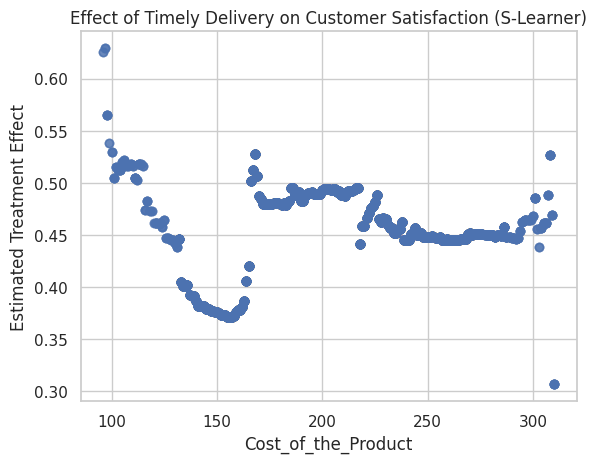

In [47]:
# モデルの構築
models = RandomForestRegressor(max_depth=3, random_state=0)

# S_learner
S_learner = SLearner(overall_model=models)

# データのリシェイプ
X_reshaped = X.values.reshape(-1, 1)

# 学習
S_learner.fit(Y, T, X=X_reshaped)

# 効果の推定
tau = S_learner.effect(X_reshaped)

# 推定された効果の可視化
plt.scatter(df_selected[["Cost_of_the_Product"]], tau, alpha=0.3)
plt.xlabel("Cost_of_the_Product")
plt.ylabel("Estimated Treatment Effect")  # どれだけ施策が顧客満足度に影響するか
plt.title("Effect of Timely Delivery on Customer Satisfaction (S-Learner)")
plt.grid(True)
plt.show()

基本的にどのコスト帯でも正になっており、商品遅延の改善は顧客満足度の改善につながるという施策は妥当でありそうだと判断できます。また、特に安い商品の改善の余地が大きいことが示唆されました。このようにして、施策の妥当性を因果推論を用いることで判断することができました。皆さんが実際に最終課題に取り組まれる際にも、活用できる場面ではぜひ使ってみてください。

#### <練習問題 10-1>
T-lernerやX-learnerを実装してみて、S-learnerで得られた仮説との同意点や相違点を考察してみましょう。

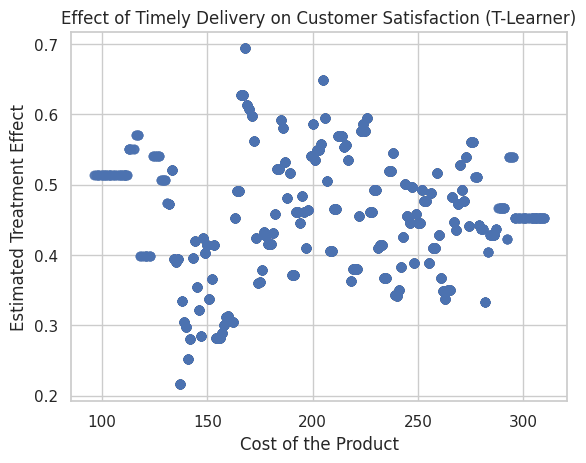

In [48]:
# データの準備
Y = df_selected['Customer_rating']  # アウトカム
T = df_selected['Reached.on.Time_Y.N']  # 処置
X = df_selected[['Cost_of_the_Product']]  # 共変量
n = len(df_selected)

# T-learnerのインスタンスを作成する
model_treated = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
model_control = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))

# 処置グループとコントロールグループに分割
X_treated = X[T == 1]
Y_treated = Y[T == 1]
X_control = X[T == 0]
Y_control = Y[T == 0]

# モデルの学習
model_treated.fit(X_treated, Y_treated)
model_control.fit(X_control, Y_control)

# 因果効果を推定する
tau = model_treated.predict(X) - model_control.predict(X)

# 推定された効果の可視化
plt.scatter(df_selected['Cost_of_the_Product'], tau, alpha=0.3)
plt.xlabel("Cost of the Product")
plt.ylabel("Estimated Treatment Effect")
plt.title("Effect of Timely Delivery on Customer Satisfaction (T-Learner)")
plt.grid(True)
plt.show()


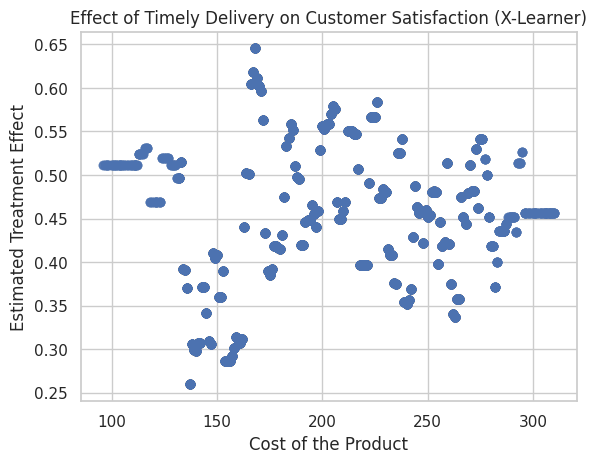

In [49]:
Y = df_selected['Customer_rating']  # アウトカム
T = df_selected['Reached.on.Time_Y.N']  # 処置
X = df_selected[['Cost_of_the_Product']]  # 共変量
n = len(df_selected)

# X-learnerのインスタンスを作成する
model_treated = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
model_control = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))

# 処置グループとコントロールグループに分割
X_treated = X[T == 1]
Y_treated = Y[T == 1]
X_control = X[T == 0]
Y_control = Y[T == 0]

# モデルの学習
model_treated.fit(X_treated, Y_treated)
model_control.fit(X_control, Y_control)

# 処置効果の差分を推定する
D_treated = Y_treated - model_control.predict(X_treated)
D_control = model_treated.predict(X_control) - Y_control

# 差分モデルの学習
model_D_treated = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
model_D_control = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
model_D_treated.fit(X_treated, D_treated)
model_D_control.fit(X_control, D_control)

# 全データに対する処置効果の推定
tau_treated = model_D_treated.predict(X)
tau_control = model_D_control.predict(X)

# 処置グループとコントロールグループのサンプルサイズに基づいて重み付け
p_treated = len(X_treated) / n
p_control = len(X_control) / n

tau = p_treated * tau_control + p_control * tau_treated

# 推定された効果の可視化
plt.scatter(df_selected['Cost_of_the_Product'], tau, alpha=0.3)
plt.xlabel("Cost of the Product")
plt.ylabel("Estimated Treatment Effect")
plt.title("Effect of Timely Delivery on Customer Satisfaction (X-Learner)")
plt.grid(True)
plt.show()


例えば、異なる学習方法によって推定される因果効果に若干の違いがあることがわかりますが、いずれもコストが低い範囲で比較的高い推定効果が得られていそうです。

#### <練習問題 10-2>
別のデータセットで因果推論を用いて施策の妥当性を検討してみましょう。（解答例などはありません。）

# おわりに
この教材では、①因果推論の基本と②機械学習を用いた因果推論について学びました。なんとなくでも大丈夫ですので、①ではセレクションバイアスを避けなければ効果検証はできないこと、②では因果推論は欠損値予測の問題であることを頭に入れてもらえるとそれだけでも最終課題に取り組むヒントになると思います！

今後勉強するないようとしては、DAGやバイアスについて詳細に学んでみること、操作変数法や差の差分析などの自然実験を活用した手法を学んでみること、機械学習を使うことで因果効果を求めることの発展的な内容（正則化バイアス）などがあると思います。下で紹介している参考文献などをあたってみてぜひ挑戦してみてください！

皆さんの最終課題の役に少しでも立てたら幸いです…！

# 参考文献
・安井翔太（2020）『効果検証入門～正しい比較のための因果推論／計量経済学の基礎』

・金本拓（2024）『因果推論：基礎から機械学習・時系列解析・因果探索を用いた意思決定のアプローチ』

# 今後の勉強のために
## 基本の確認
・ジュディア・パール（2022）『因果推論の科学「なぜ？」の問いにどう答えるのか』

・林岳彦（2024）『はじめての統計的因果推論』

## 応用編
・末石直也（2015）『計量経済学　ミクロデータ分析へのいざない』

・齋藤優太（2024）『反実仮想機械学習〜機械学習と因果推論の融合技術の理論と実践』

## データ
・メールマーケティングのデータ：https://blog.minethatdata.com/2008/03/minethatdata-e-mail-analytics-and-data.html

・就労支援プログラムのデータ：https://users.nber.org/~rdehejia/nswdata2.html
